In [1]:
using POMDPs # for MDP type
using DiscreteValueIteration
using POMDPPolicies
using POMDPModelTools #for sparse cat 
using Parameters
using Random
using Plots; default(fontfamily="Computer Modern", framestyle=:box) # LaTex-style
using QuickPOMDPs
using Distributions 
#using PlotlyJS
using LinearAlgebra
using POMDPSimulators

In [2]:
Random.seed!(0xC0FFEE)

MersenneTwister(12648430)

**States**

In [3]:
# A state s in the evacuation problem is a discrete set of 4 values: 
# chairs remaining, time remaining, family size, and visa status
struct State
    c::Int # chairs remaining 
    t::Int # time remaining 
    f::Int # family size 
    v::Int # visa status 
end 

**Environment Parameters**

In [ ]:
# # OLD ENVIRONMENT PARAMETERS THAT WORKED before adding weights etd. 
# @with_kw struct EvacuationParameters
#     # could add threshold here 
#     family_sizes::Vector{Int} = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] # set with no repeats 
#     # p_family_sizes::Vector{Float} = # must sum to 1 
#     visa_status::Vector{Int} = [-5, -4, -3, -2, -1, 1, 2, 3, 4, 5] #TODO: map to various status 
#     # p_visa_status::Vector{Float} = # must sum to 1 
#     capacity::Int = 60
#     time::Int = 60
#     size::Tuple{Int, Int} = (length(visa_status), length(family_sizes)) # size of grid 
#     p_transition::Real = 0.8 # don't we always transition into this since time moves forward? I'm confused... 
#     null_state::State = State(-1, -1, -1 ,-1) # is there someway to do this???
# end


In [4]:
@with_kw struct EvacuationParameters
    family_sizes::Vector{Int} = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] # set with no repeats 
    family_prob = [1/25, 1/25, 3/25, 4/25, 5/25, 4/25, 3/25, 2/25, 1/25, 1/25]
    visa_status::Vector{Int} = [-5, -4, -3, -2, -1, 1, 2, 3, 4, 5] #TODO: map to various status 
    visa_prob = [.05, .05, .5, .1, .15, .05, .05, .05]
    # p_visa_status::Vector{Float} = # must sum to 1 
    capacity::Int = 60 # keeping these both as integers of 20 for now. 
    time::Int = 60
    size::Tuple{Int, Int} = (length(visa_status), length(family_sizes)) # size of grid 
    p_transition::Real = 0.8 # don't we always transition into this since time moves forward? I'm confused... 
    null_state::State = State(-1, -1, -1 ,-1) # is there someway to do this???
    accept_prob = [.80, .20]
    reject_prob = [1.0]
end


EvacuationParameters

In [5]:
params = EvacuationParameters(); 

In [6]:
@show number_states = params.capacity * params.time * size(params.family_sizes)[1] * size(params.visa_status)[1]

number_states = params.capacity * params.time * (size(params.family_sizes))[1] * (size(params.visa_status))[1] = 360000


360000

In [7]:
# The state space S for the evacuation problem is the set of all combinations 
𝒮 = []
for c in 0:params.capacity # capacity ends at 0 
    for t in 0:params.time # time ends at 0 
        for f in params.family_sizes # family size here we should have the ACTUAL family sizes 
            for v in params.visa_status # actual visa statuses 
                new = State(c, t, f, v) 
                𝒮 = [𝒮; new]
            end
        end        
    end
end
𝒮 = [𝒮; params.null_state]




372101-element Vector{Any}:
 State(0, 0, 1, -5)
 State(0, 0, 1, -4)
 State(0, 0, 1, -3)
 State(0, 0, 1, -2)
 State(0, 0, 1, -1)
 State(0, 0, 1, 1)
 State(0, 0, 1, 2)
 State(0, 0, 1, 3)
 State(0, 0, 1, 4)
 State(0, 0, 1, 5)
 State(0, 0, 2, -5)
 State(0, 0, 2, -4)
 State(0, 0, 2, -3)
 ⋮
 State(60, 60, 9, 5)
 State(60, 60, 10, -5)
 State(60, 60, 10, -4)
 State(60, 60, 10, -3)
 State(60, 60, 10, -2)
 State(60, 60, 10, -1)
 State(60, 60, 10, 1)
 State(60, 60, 10, 2)
 State(60, 60, 10, 3)
 State(60, 60, 10, 4)
 State(60, 60, 10, 5)
 State(-1, -1, -1, -1)

**Actions**

In [8]:
# the possible actions are whether accept or reject a family at the gate 
@enum Action REJECT ACCEPT

In [9]:
𝒜 = [REJECT, ACCEPT]

2-element Vector{Action}:
 REJECT::Action = 0
 ACCEPT::Action = 1

In [10]:
# only inbounds if room for the family [assuming would not separate even though might]
# and if time is available to enter the airport 
validtime(s::State) = 0 < s.t 

validtime (generic function with 1 method)

In [11]:
validcapacity(s::State) = 0 ≤ s.c # maybe try back to 0 

validcapacity (generic function with 1 method)

**Transition Function** 

In [14]:
#**************************OLD TRANSITION FUNCTION JUST KEEPING CUZ IT WORKED **************************
# just using it to debug other parts of the code right now 
function T(s::State, a::Action)
    next_states = []
    if validtime(s) 
        
        f′ = rand(params.family_sizes) # pull according to those probabilities 
        v′ = rand(params.visa_status) # TODO: possibly make this weighted in some way 
        # keep pushing to next states and have a bigger associated probability mass with those possible next states. 
        # need a for loop iterating over all family sizes and and visa statuses 
        
        if a == ACCEPT 
            next_state_accept = State(s.c - s.f, s.t - 1, f′, v′) # they get seats
            next_state_reject = State(s.c, s.t - 1, f′, v′)
            push!(next_states, next_state_accept)
            push!(next_states, next_state_reject)
            if !validcapacity(next_state_accept) 
                probabilities = [0, 1] #no room for full family :( so we make probability 0 to accept and 1 reject
            else
                probabilities = [.80, .20]
            end

        elseif a == REJECT
            probabilities = [1.0]
            push!(next_states, State(s.c, s.t - 1, f′, v′))
        end
    else
        push!(next_states,params.null_state)
        probabilities = [1]
    end
    return SparseCat(next_states, probabilities)
end


T (generic function with 1 method)

In [13]:
#***** DEBUG WEDNESDAY NIGHT******

# function T(s::State, a::Action)
#     #c::Int # chairs remaining 
#     #t::Int # time remaining 
#     #f::Int # family size 
#     #v::Int # visa status 
#     next_states = []
#     probabilities = [] 

#     if validtime(s) 
        
#         #if accept
#         if a == ACCEPT 
#             if !validcapacity(next_state_accept) 
#                 prob = [0,1] #no room for full family :( so we make probability 0 to accept and 1 reject
#             else
#                 prob = params.accept_prob
            
#             for f in length(params.family_size)
#                 for v in length(params.visa_status)
#                     #if get on plane
#                     push!(next_states, State(s.c - s.f, s.t - 1, params.family_sizes[f], params.visa_status[v]))
#                     push!(probabilities, prob[1] * visa_prob[v] * family_prob[f])
#                     #if not
#                     push!(next_states, State(s.c, s.t - 1, params.family_sizes[f], params.visa_status[v]))
#                     push!(probabilities, prob[2] * visa_prob[v] * family_prob[f])                    
#                 end
#             end
        
                
                
#         else   #if reject     
#             for f in length(params.family_size)
#                 for v in length(params.visa_status)
#                     push!(next_states, State(s.c, s.t - 1, params.family_sizes[f], params.visa_status[v]))
#                     push!(probabilities, params.reject_prob[1] * visa_prob[v] * family_prob[f])    
#                 end
#             end            
#     end                
                    
#     return SparseCat(next_states, probabilities)
# end
        

LoadError: syntax: "if" at In[13]:13 expected "end", got "else"

**Reward Function**

In [15]:
function R(s::State, a::Action)
    # reward is just the visa status times family size i think! 
    if a == ACCEPT
        return s.v*s.f
    end
    return 0
end 

R (generic function with 1 method)

In [16]:
#render(mdp; show_rewards=true)
#@bind γ Slider(0:0.05:1, default=0.95, show_value=true)
# hard code for now. maybe come back to it. 
γ = 0.95

0.95

In [17]:
termination(s::State)= s == params.null_state # change to 1 or the other 

termination (generic function with 1 method)

**MDP Formulation**

In [18]:
# We define the Airport abstract MDP type so we can reference it in other methods.
abstract type Evacuation <: MDP{State, Action} end

In [19]:
c_initial = params.capacity
t_initial = params.time
f_initial = rand(params.family_sizes, 1)[1]
v_initial = rand(params.visa_status, 1)[1]

initial_state = State(c_initial, t_initial, f_initial, v_initial)

State(60, 60, 9, -1)

In [20]:
statetype = typeof(initial_state)
initialstate_array = [initial_state]

1-element Vector{State}:
 State(60, 60, 9, -1)

In [22]:
mdp = QuickMDP(Evacuation,
    states       = 𝒮,
    actions      = 𝒜,
    transition   = T,
    reward       = R,
    discount     = γ,
    initialstate = initialstate_array, 
    isterminal   = termination,
    render       = render,
    statetype    = statetype 
    );

In [23]:
solver = ValueIterationSolver(max_iterations=30, belres=1e-6, verbose=true);

**Policy**

In [24]:
policy = solve(solver, mdp) 

[Iteration 1   ] residual:        363 | iteration runtime:   1394.585 ms, (      1.39 s total)
[Iteration 2   ] residual:        133 | iteration runtime:   1298.927 ms, (      2.69 s total)
[Iteration 3   ] residual:        134 | iteration runtime:   1323.886 ms, (      4.02 s total)
[Iteration 4   ] residual:        147 | iteration runtime:   1304.364 ms, (      5.32 s total)
[Iteration 5   ] residual:        135 | iteration runtime:   1320.498 ms, (      6.64 s total)
[Iteration 6   ] residual:        132 | iteration runtime:   1293.174 ms, (      7.94 s total)
[Iteration 7   ] residual:        137 | iteration runtime:   1286.505 ms, (      9.22 s total)
[Iteration 8   ] residual:        131 | iteration runtime:   1280.487 ms, (      10.5 s total)
[Iteration 9   ] residual:        147 | iteration runtime:   1300.546 ms, (      11.8 s total)
[Iteration 10  ] residual:        143 | iteration runtime:   1297.982 ms, (      13.1 s total)
[Iteration 11  ] residual:        134 | iteration 

ValueIterationPolicy:
 State(0, 0, 1, -5) -> REJECT
 State(0, 0, 1, -4) -> REJECT
 State(0, 0, 1, -3) -> REJECT
 State(0, 0, 1, -2) -> REJECT
 State(0, 0, 1, -1) -> REJECT
 State(0, 0, 1, 1) -> ACCEPT
 State(0, 0, 1, 2) -> ACCEPT
 State(0, 0, 1, 3) -> ACCEPT
 State(0, 0, 1, 4) -> ACCEPT
 State(0, 0, 1, 5) -> ACCEPT
 State(0, 0, 2, -5) -> REJECT
 State(0, 0, 2, -4) -> REJECT
 State(0, 0, 2, -3) -> REJECT
 State(0, 0, 2, -2) -> REJECT
 State(0, 0, 2, -1) -> REJECT
 State(0, 0, 2, 1) -> ACCEPT
 State(0, 0, 2, 2) -> ACCEPT
 State(0, 0, 2, 3) -> ACCEPT
 State(0, 0, 2, 4) -> ACCEPT
 State(0, 0, 2, 5) -> ACCEPT
 State(0, 0, 3, -5) -> REJECT
 State(0, 0, 3, -4) -> REJECT
 State(0, 0, 3, -3) -> REJECT
 State(0, 0, 3, -2) -> REJECT
 State(0, 0, 3, -1) -> REJECT
 …

**Basesline Policies**

In [ ]:
# Examples of how to make policies: 
https://htmlview.glitch.me/?https://github.com/JuliaAcademy/Decision-Making-Under-Uncertainty/blob/master/html/2-POMDPs.jl.html

In [119]:
"""AcceptAll"""
struct AcceptAll <: Policy end

# accept everyone until capacity is 0
function POMDPs.action(::AcceptAll, s::State)    # action(policy, state)
    return ((s.c-s.f) >= 0 && s.t >= 0) ? ACCEPT : REJECT
end;

# struct test <: Policy end
# # accept everyone until capacity is 0
# function POMDPs.action(::test, s::State)    # action(policy, state)
#     return ACCEPT 
# end;
# test_policy = test()


# make sure these aren't the same name 
AcceptAll_policy = AcceptAll()

#simulations(AcceptAll_policy, mdp, 100) #how it will be called 

(-8.403476234984945, 50.793523389887135)

In [117]:
#simulations(test_policy, mdp, 100) #how it will be called 

In [120]:
"""AMCITS"""
struct AMCITS <: Policy end

function POMDPs.action(::AMCITS, s::State)
    return (s.v == 5 && (s.c-s.f) >= 0 && s.t >= 0) ? ACCEPT : REJECT
end;

AMCITS_policy = AMCITS()

# simulations(AMCITS_policy, mdp, 10) how it will be called 

AMCITS()

In [122]:
"""SIV_AMCITS """
struct SIV_AMCITS <: Policy end

function POMDPs.action(::SIV_AMCITS, s::State)
    return (((s.c-s.f) >= 0 && s.t >= 0) && s.v == 5 || s.v == 4) ? ACCEPT : REJECT
end;
SIV_AMCITS_policy = SIV_AMCITS()


# simulations(SIV_AMCITS_policy, mdp, 10) how it will be called 

SIV_AMCITS()

In [123]:
"""AfterThresholdAMCITS"""
# if want to change this need to make it a mutable struct 
@with_kw struct AfterThresholdAMCITS <: Policy
    threshold = 20 # could define this in parameters 
end

function POMDPs.action(::AfterThresholdAMCITS, s::State)
    # regular MDP up until that point 
    return (((s.c-s.f) >= 0 && s.t >= 0) && s.t <= 20 && s.v == 5) ? ACCEPT : REJECT # make the threshold a variable 
end;
        
SIV_AfterThresholdAMCITS_policy = AfterThresholdAMCITS()
simulations(SIV_AfterThresholdAMCITS_policy, mdp, 10)


(5.6689258056683, 3.6467736473245473)

In [126]:
"""BeforeThresholdAMCITS"""
@with_kw struct BeforeThresholdAMCITS <: Policy
    threshold = 20
end
# SOMETHING WRONG HERE... with the policy. want regular until threshold and then only amcits 
function POMDPs.action(::BeforeThresholdAMCITS, s::State)
    # regular MDP up until that point 
    return (((s.c-s.f) >= 0 && s.t >= 0) && s.t => 20 && s.v == 5) ? ACCEPT : REJECT # make the threshold a variable 
end;
        
BeforeThresholdAMCITS_policy = AfterThresholdAMCITS()
simulations(BeforeThresholdAMCITS_policy, mdp, 10)
# could play with changing this threshold


(4.615934192734884, 3.2769627102130485)

**Simulation**

In [63]:
function simulation(policy, mdp)
    sim = RolloutSimulator()
    r = simulate(sim, mdp, policy) #accumulated discounted reward 
    # could we also return the number of ppl on the plane? 
    return r
end

simulation (generic function with 1 method)

In [64]:
function simulations(policy, mdp, n_sims) # n is number of times to run 
    policy_rewards = []
    for i in 1:n_sims
        push!(policy_rewards, simulation(policy, mdp))
    end
    std_policy_reward = std(policy_rewards)
    mean_policy_reward = mean(policy_rewards)
    return mean_policy_reward, std_policy_reward
end

simulations (generic function with 1 method)

In [101]:
function experiments()
    # policies and n_sims can probably be put in our params function as a list. here for now. 
    n_sims = 100
    policies = [AcceptAll_policy, AMCITS_policy, 
        SIV_AMCITS_policy, SIV_AfterThresholdAMCITS_policy, 
        BeforeThresholdAMCITS_policy]
    m_std_rewards = []
    for curr_policy in policies
        push!(m_std_rewards, simulations(curr_policy, mdp, n_sims))
    end
    # Could print them in a way that makes it more fun 
    return m_std_rewards

end

experiments (generic function with 1 method)

In [102]:
mean_std_rewards = experiments()

5-element Vector{Any}:
 (-7.733198567563802, 57.93928993359383)
 (53.616929173316436, 27.264140584272177)
 (84.02768830285642, 31.153320311754797)
 (4.267395983219259, 3.2769769805601263)
 (4.1915157450621505, 3.847280153426242)

**Visualizations**

In [107]:

function vis_time_step(policy, c, t) # pass in policy and chairs and time remaing. Spit out graph of family size versus visa status.
    (v_size, f_size) = params.size  #visa, family 8, 15
    policyGraph = zeros(v_size, f_size) #8 by 15 matrix of zeroes
    visa_statuses=params.visa_status
    family_sizes=params.family_sizes
    
    for f in 1:f_size
        for v in 1:v_size
            act = action(policy, State(c, t, family_sizes[f], visa_statuses[v])) 
            if act == ACCEPT
                policyGraph[v,f] = 100
            else
                policyGraph[v,f] = 0
            end
        end
    end
    
    x=params.visa_status
    y=params.family_sizes
    z=policyGraph'
    title_time_cap="t = $t c = $c " # MAKE title smaller 
    return heatmap(x, y, z, aspect_ratio = 1, legend = :none, xlims = (-5,5), xlabel = "Visa Status", ylabel = "Family Size", ylims = (1,10), title=title_time_cap )
    
end

vis_time_step (generic function with 1 method)

In [129]:
function vis_all(policy)
    total_time = params.time 
    total_capacity = params.capacity
    total_graphs = total_time*total_capacity
    heat_maps = []
    time_points = total_time/20 
    capacity_points = total_capacity/20 
    num_graphs = 16 #trunc(Int,((total_time*total_capacity/20^2))) # math we can do 

    
    for t in 0:total_time
        if t % 20 == 0 
            for c in 0:total_capacity
                if c % 20 == 0
                push!(heat_maps, vis_time_step(policy, c, t))
                end
            end
        end
    end 
    plot(heat_maps..., layout=num_graphs)
end

vis_all (generic function with 1 method)

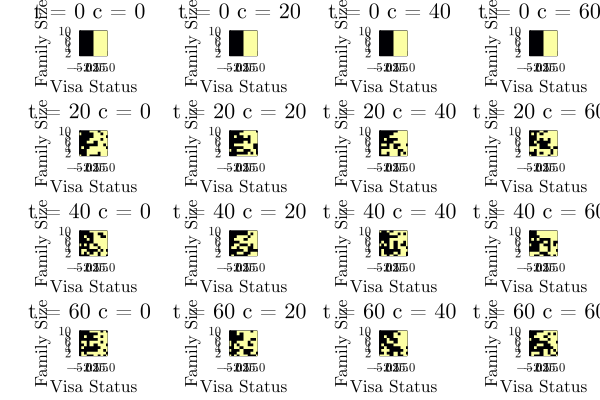

In [130]:
vis_all(policy)

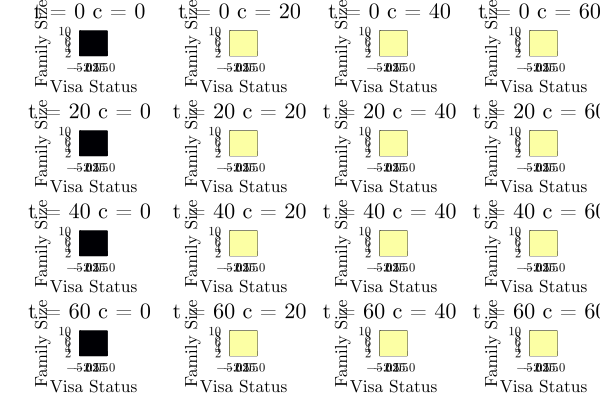

In [131]:
vis_all(AcceptAll_policy)

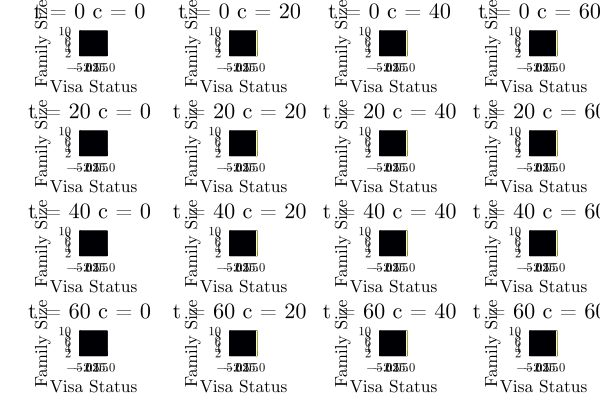

In [132]:
vis_all(AMCITS_policy) 

       

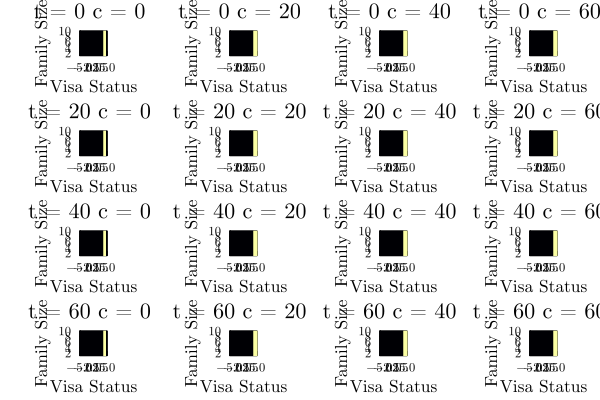

In [133]:
vis_all(SIV_AMCITS_policy)

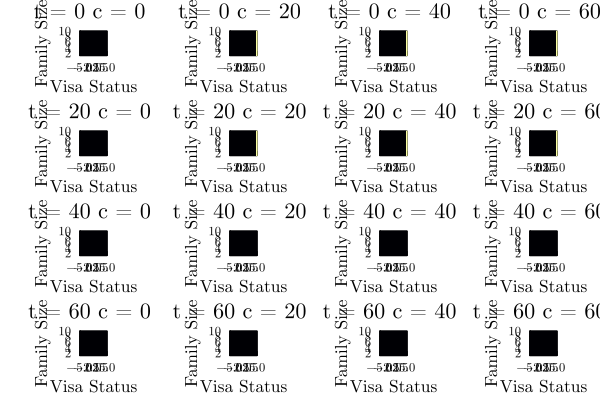

In [134]:
vis_all(SIV_AfterThresholdAMCITS_policy)


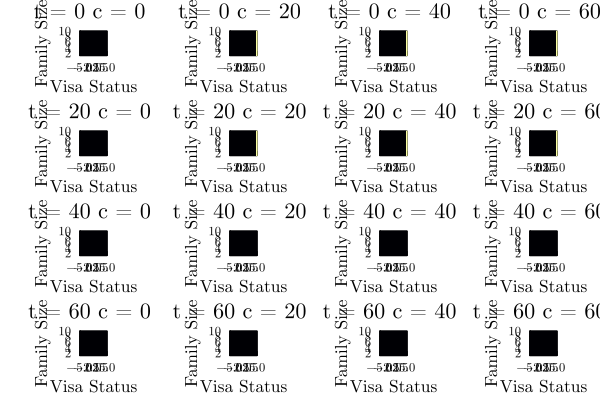

In [135]:
vis_all(BeforeThresholdAMCITS_policy)

**Aggregate Metrics**

In [ ]:
function getmetrics(policy, mdp)
    # I think this somehow needs to simulated in our rollout 
    total_people = 0
    total_accept = 0
    total_reject = 0
    total_accepted_people = 0 
    
    # Initialize visa_statuses dictionary
    visa_statuses = params.visa_status
    visa_dict = Dict()
    for v in visa_statuses
        visa_dict[v] = 0
    end
    
    for c in 0:params.capacity # capacity ends at 0 
        for t in 0:params.time # time ends at 0 
            for f in params.family_sizes # family size here we should have the ACTUAL family sizes 
                for v in params.visa_status # actual visa statuses  
                    state = State(c, t, f, v)
                    total_people += f 
                    if action(policy, state) == ACCEPT
                        total_accept += 1
                        total_accepted_people += f
                        visa_dict[v] += 1
                    else 
                        total_reject += 1
                    end
                end        
            end
        end
    end
    
    print("Total people: ", total_people, )
    print("Total accept: ", total_accept)
    print("Total reject: ", total_reject)
    visa_dict 
       
end 

In [ ]:
getmetrics(policy, mdp)